# Removing noise from `our special` Kepler `target`

## Obtaining the CBVs

In [1]:
from lightkurve import search_lightcurve
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
lc = search_lightcurve('KIC 4997179', quarter=10).download(flux_column='sap_flux')

Next, we create a `CBVCorrector` object. This will download the CBVs appropriate for this target and store them in the `CBVCorrector` object. In the case of TESS, this means the CBVs associated with the CCD this target is on and for Sector 10.

In [3]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(lc)

Let's look at the CBVs downloaded.

In [4]:
cbvCorrector.cbvs

[Kepler CBVs, Quarter.Module.Output : 10.6.1, nCBVs : 16]

We see that there are a total of 5 sets of CBVs, all associated with TESS Sector 10, Camera 1 and CCD 1. The number of CBVs per type is also given. Let's plot the Single-Scale CBVs, which contain all systematics combined.

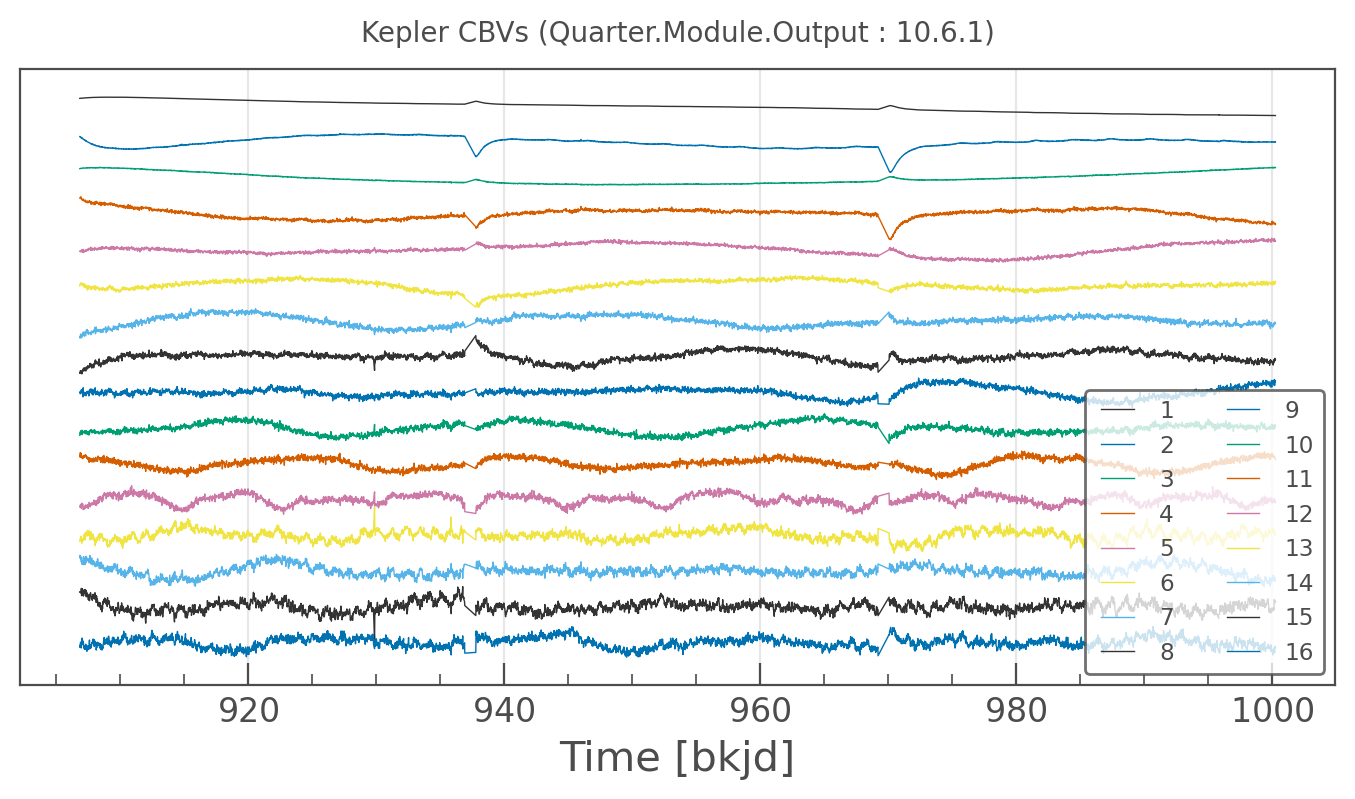

In [5]:
cbvCorrector.cbvs[0].plot();

The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs.

## Example Correction with CBVCorrector to Inhibit Over-Fitting

In [6]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9)]
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
906.8464552195001,7.0499610e+03,3.0312879e+00,0,3.022399e-03,473.23530,24.35878,39049,6.9266479e+03,3.0312879e+00,6.2332690e+02,3.0575430e-01,———,———,0,———,———,———,———,473.23530,5.4035272e-04,24.35878,5.3737068e-04,-4.8440292e-02,-1.2506612e-01
906.8668894878356,7.0497721e+03,3.0314955e+00,0,3.022968e-03,473.23552,24.35865,39050,6.9264590e+03,3.0314956e+00,6.2451129e+02,3.0574101e-01,9.1494219e+03,3.9196181e+00,0,———,———,———,———,473.23552,5.4026255e-04,24.35865,5.3739105e-04,-4.8481617e-02,-1.2505126e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000.2276169520046,7.0500198e+03,3.0482430e+00,0,2.613632e-03,473.32734,24.57157,43619,7.0947710e+03,3.0482430e+00,6.2696338e+02,3.0526137e-01,9.1653369e+03,3.9512844e+00,0,———,———,———,———,473.32734,5.4269930e-04,24.57157,5.4473052e-04,5.3210855e-02,1.3209906e-01
1000.2480498218501,7.0592837e+03,3.0489256e+00,0,2.612902e-03,473.32602,24.57103,43620,7.1025103e+03,3.0489256e+00,6.2645667e+02,3.0557996e-01,9.1727100e+03,3.9514701e+00,0,———,———,———,———,473.32602,5.4185931e-04,24.57103,5.4379320e-04,5.3143997e-02,1.3232988e-01
1000.2684825914621,7.0533986e+03,3.0485453e+00,0,2.612171e-03,473.32954,24.57038,43621,7.0975186e+03,3.0485454e+00,6.2656921e+02,3.0511710e-01,9.1645410e+03,3.9508810e+00,0,———,———,———,———,473.32954,5.4183998e-04,24.57038,5.4375647e-04,5.3363580e-02,1.3203950e-01


Does not work!

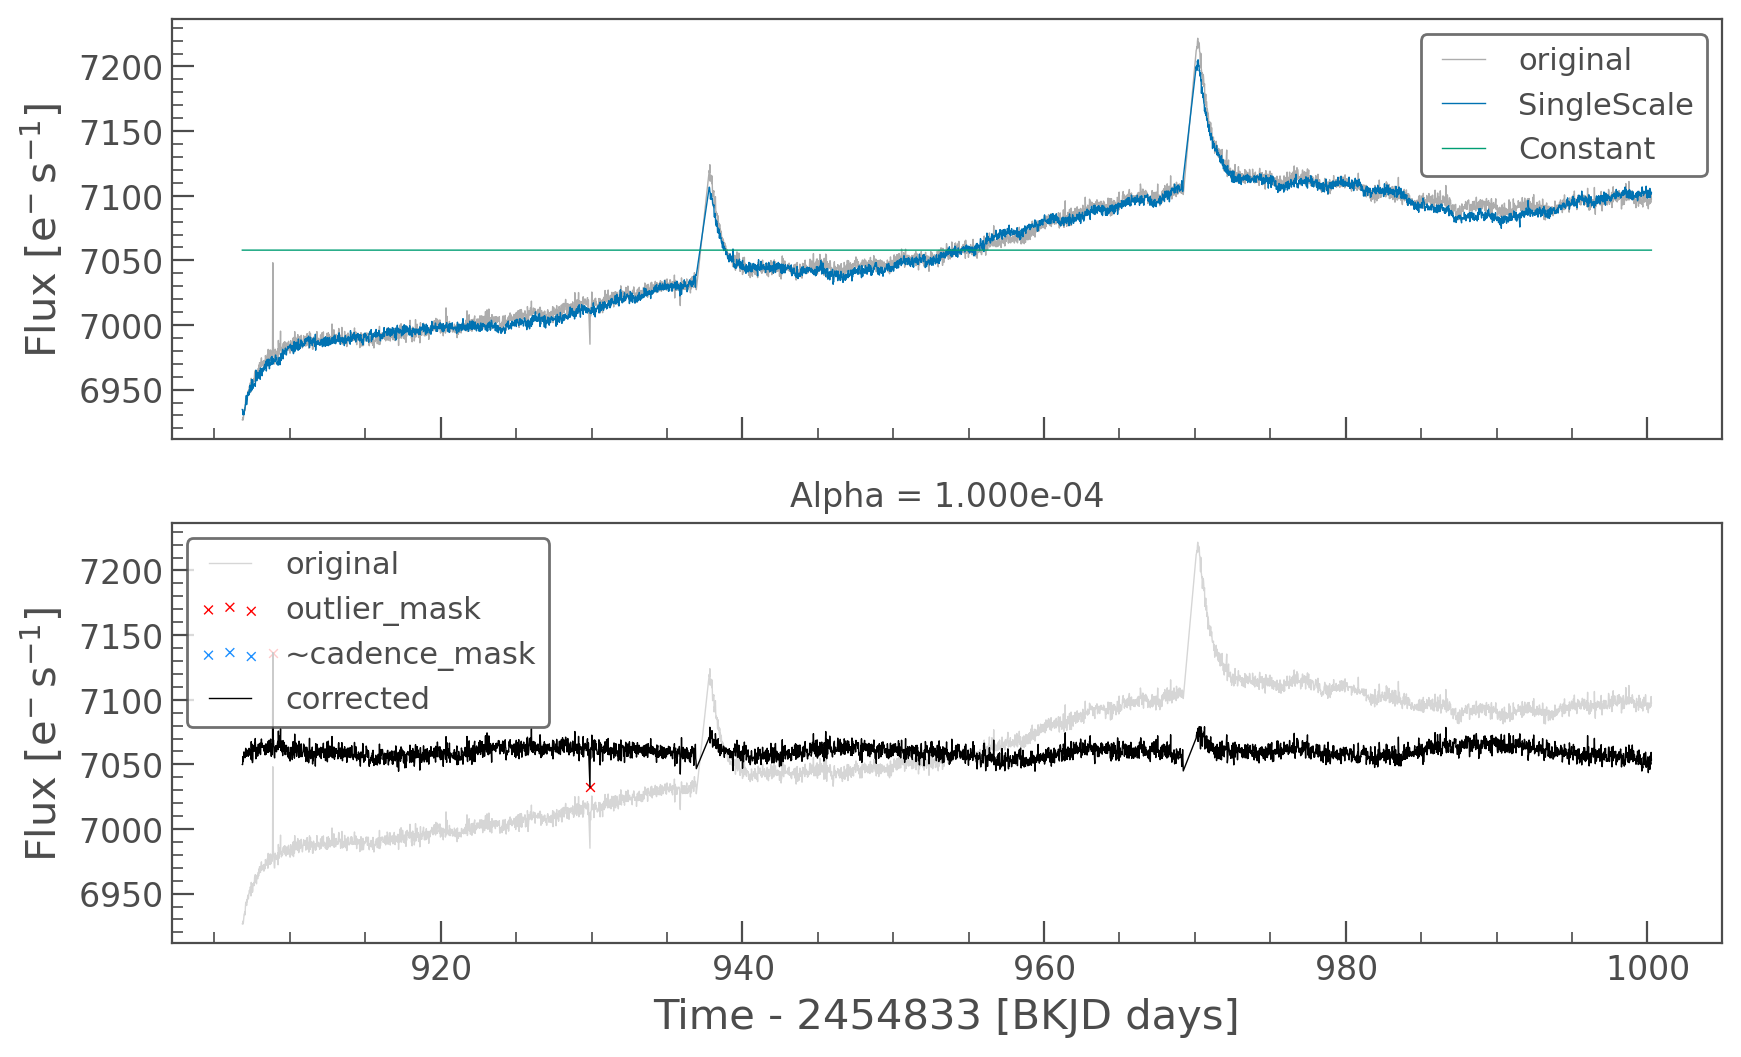

In [7]:
cbvCorrector.diagnose();

In [8]:
# Note: this cell will be slow to run
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

Over fitting Metric: 0.7045617691582625
Under fitting Metric: 0.999703139103968


## Using the Goodness Metrics to Optimize the Fit

We will start by performing a scan of the over- and under-fit goodness metrics as a function of the L2-Norm regularization term, alpha.

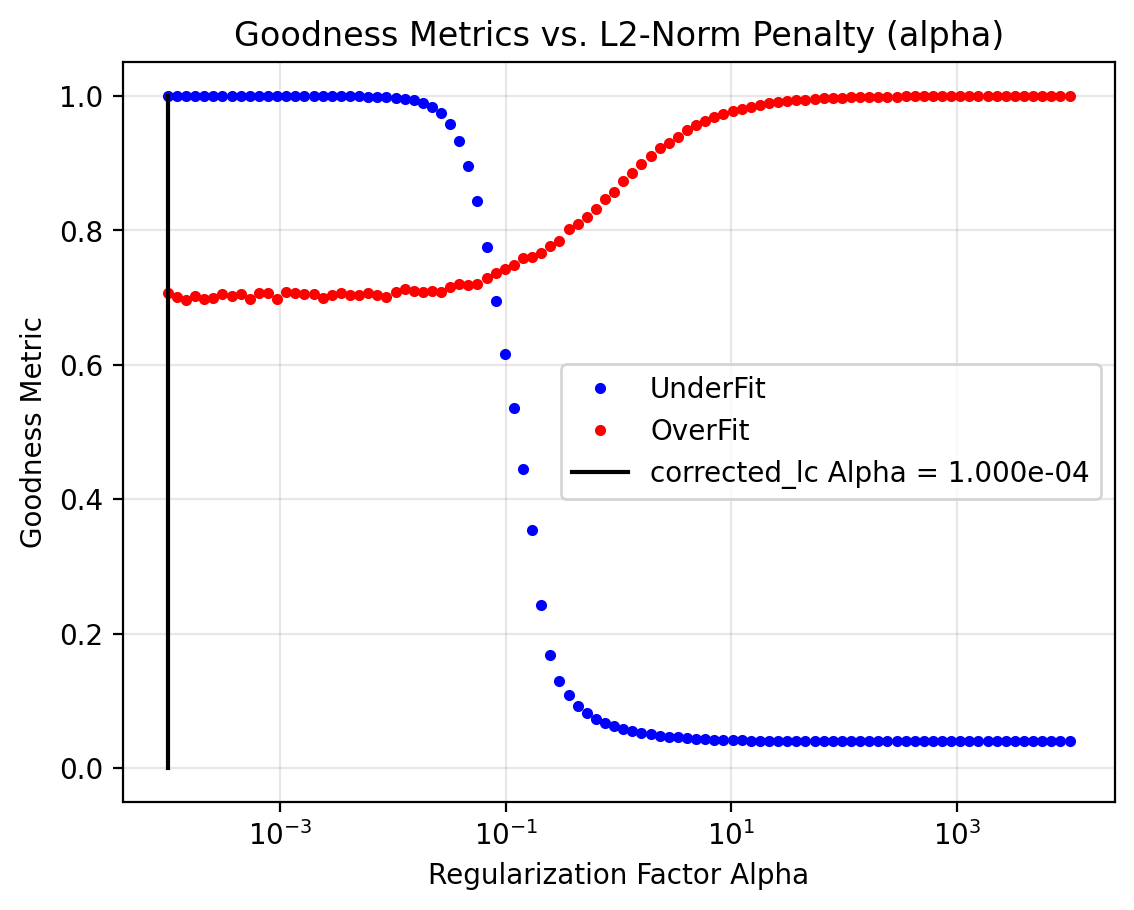

In [9]:
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

This scan also plots the last used alpha parameter as a vertical black line (alpha=1e-4 in our case). We are clearly not optimizing this fit for both over- and under-fitting. Let's use the `correct` numerical optimizer to try to optimize the fit.

Optimized Over-fitting metric: 0.7072437474811886
Optimized Under-fitting metric: 0.9971147570274682
Optimized Alpha: 1.092e-02


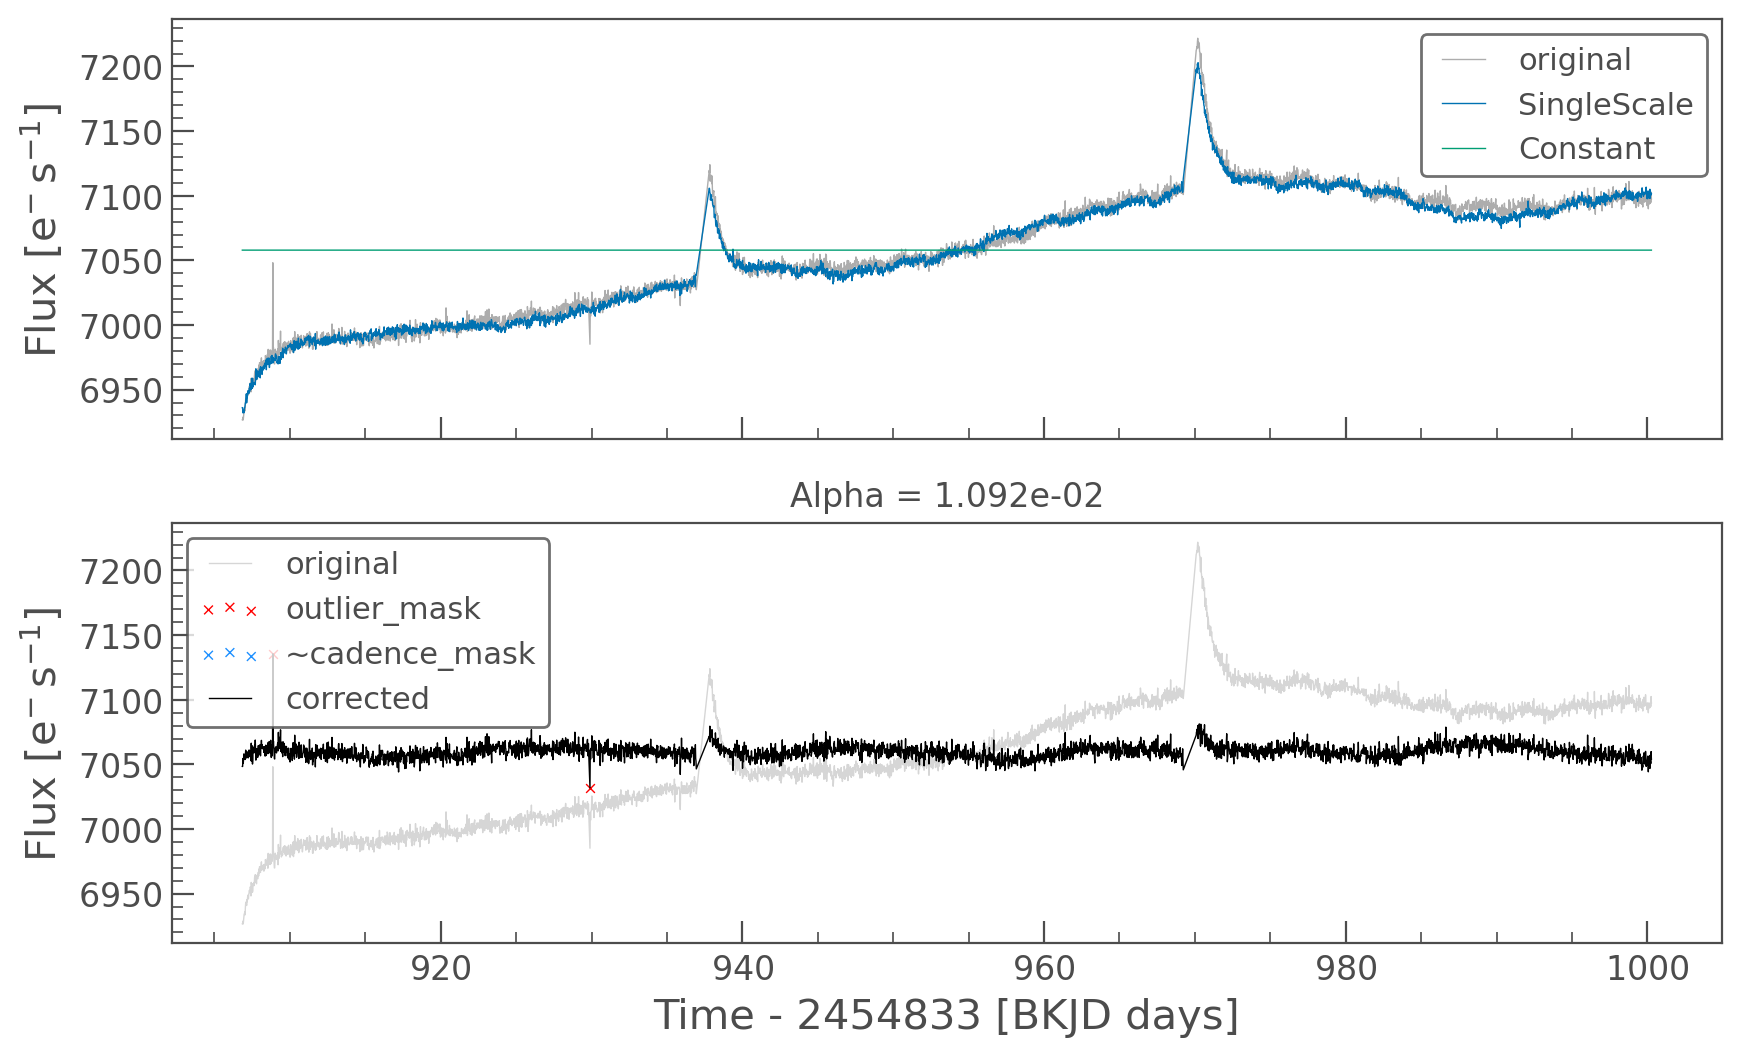

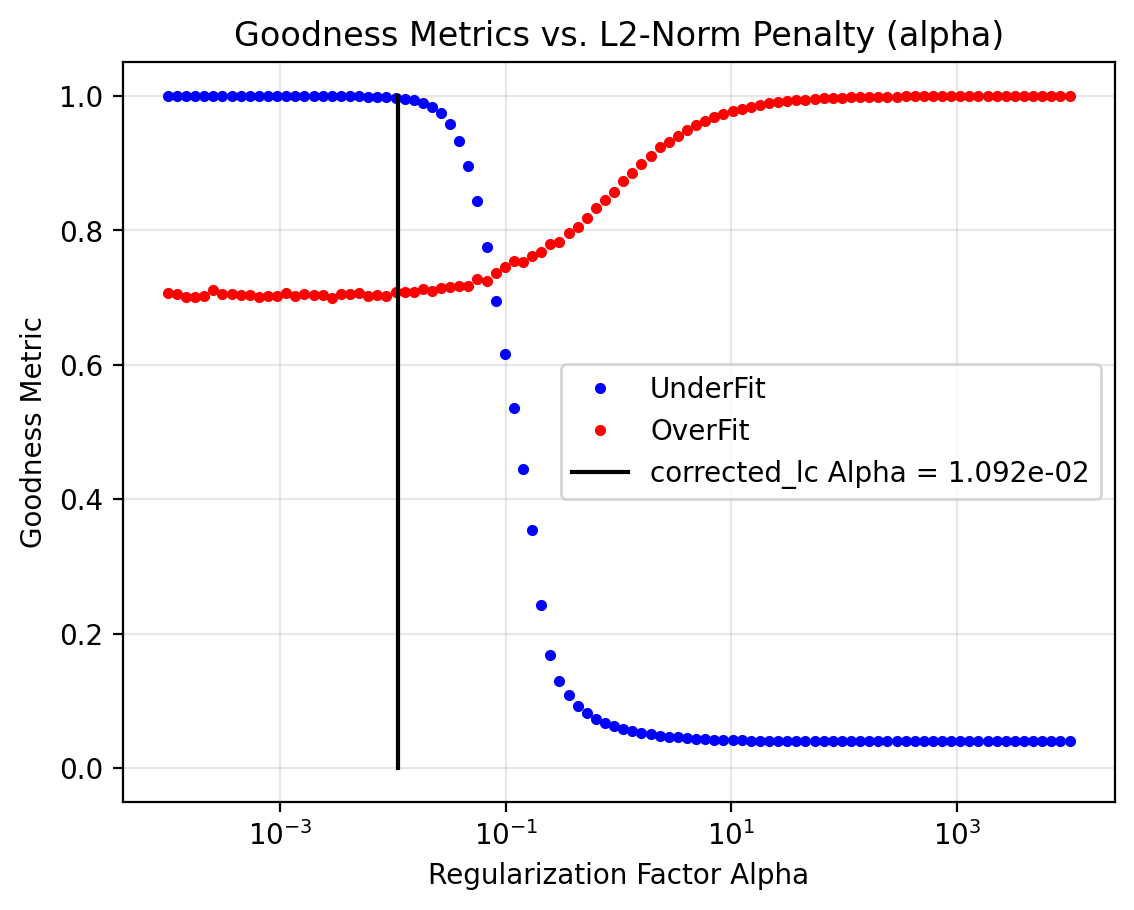

In [10]:
cbvCorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices);
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Much better! We see the thermal settling systematic is still being removed, but the stellar variabity is better preserved. Note that the optimizer did not set the alpha parameter at exactly the red and blue curve intersection point. The default target goodness scores is 0.8 or above, which is fulfilled at alpha=1.45e-1. If we want to optimize the fit even more, by perhaps ensuring we are not over-fitting at all, then we can adjust the target over and under scores to emphasize which metric we are more interested in. Below we more greatly emphasize improving the over-fitting metric by setting the target to 0.9.

Optimized Over-fitting metric: 0.8984148301501381
Optimized Under-fitting metric: 0.05207888943264036
Optimized Alpha: 1.598e+00


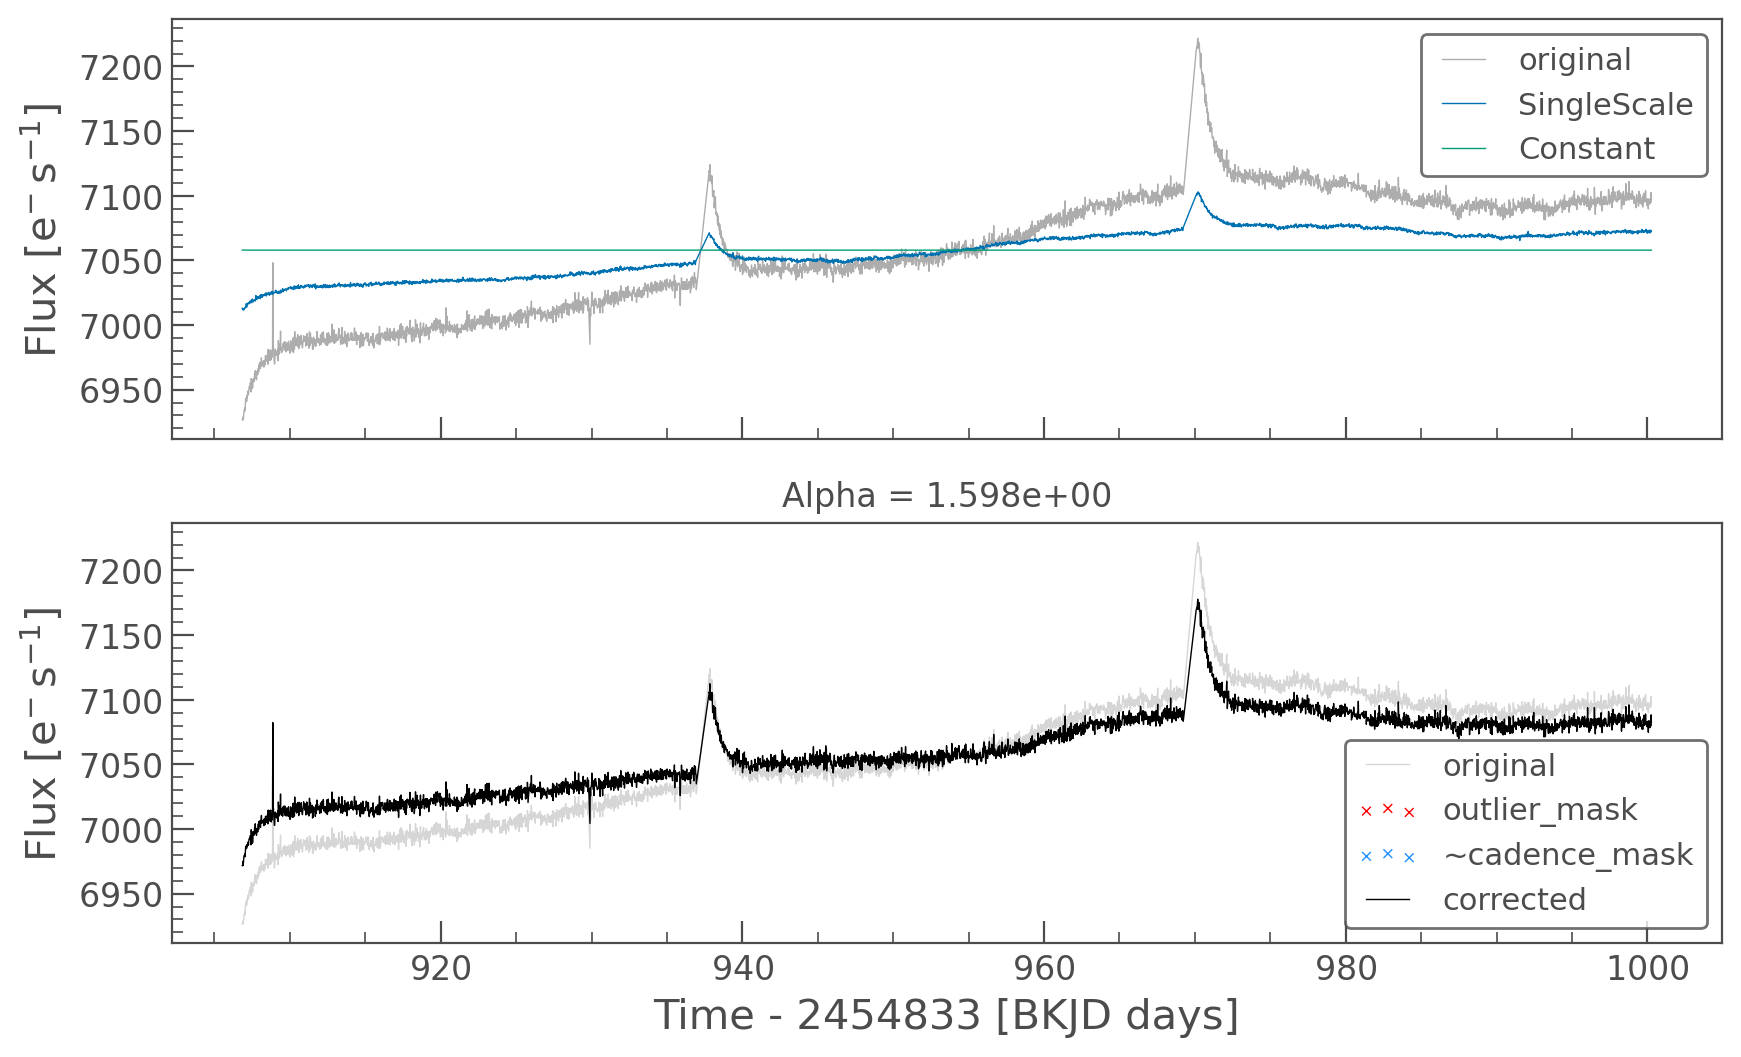

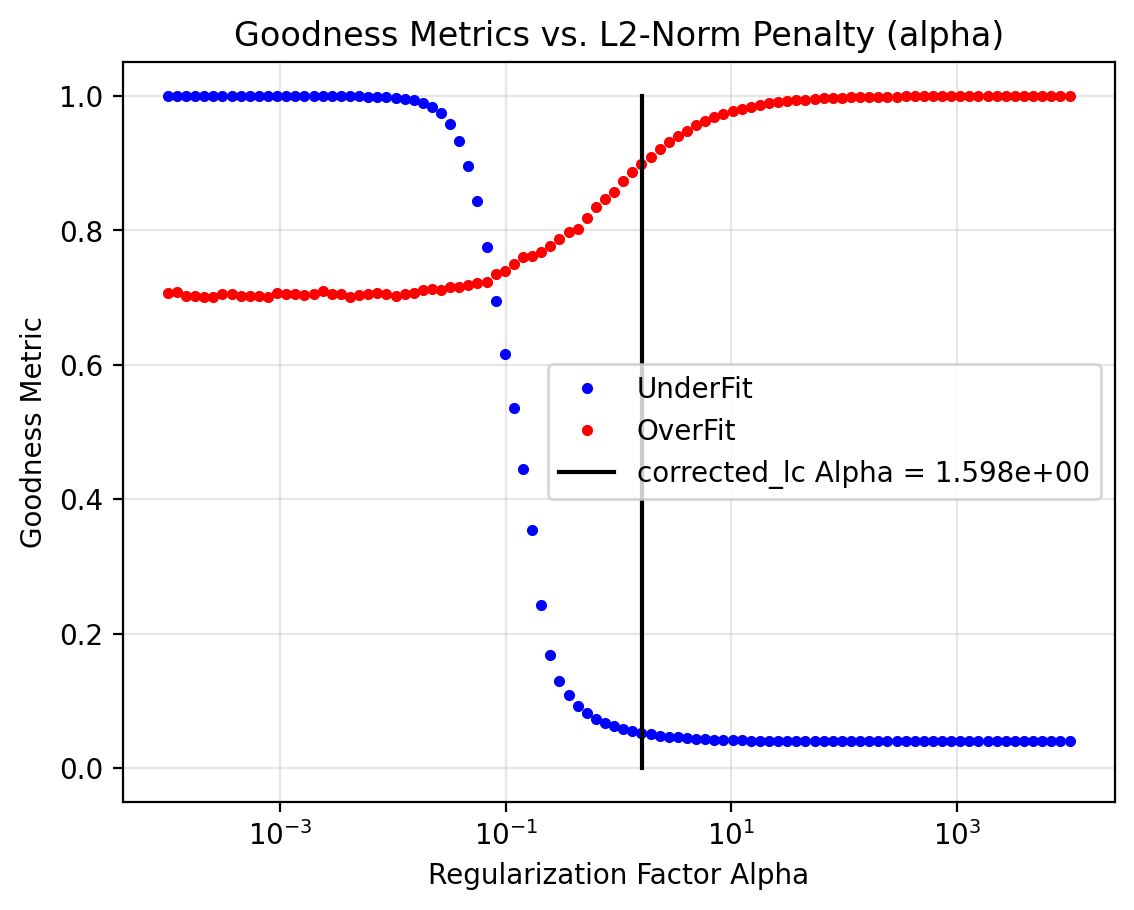

In [11]:
cbvCorrector.correct(cbv_type=cbv_type,
                     cbv_indices=cbv_indices, 
                     target_over_score=0.9,
                     target_under_score=0.5)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

We are now perhaps biasing too far towards under-fitting, but depending on your research interests, this might be best.

## ...Or Can We Still Do Better?

Perhaps we are using the incorrect CBVs for this target. Below is a tuned multi-step fit where we first fit the multi-scale Band 2 CBVs then the Spike CBVs. The multi-scale band 2 CBVs contain intermediate frequency systematic signals. They should not inject high frequency noise. We also utilize the `correct_elasticnet` corrector, which allows us to add in a L1-Norm term (Lasso Regularization). L1-Norm helps snap some basis vector fit coefficients to zero and can result in a more stable, less noisy fit. The result is a much better compromise between over- and under-fitting. The spikes are not well removed but increasing the weight on the Spike CBV removal results in over-fitting. We can also try the multi-scale band 3 CBVs, which contain high frequency systematics, but the over-fitting metric indicates using them results in even greater over-fitting. The resultant is now much better than what we achieved above but more tuning and optimization could possibly get us even closer to an ideal fit.

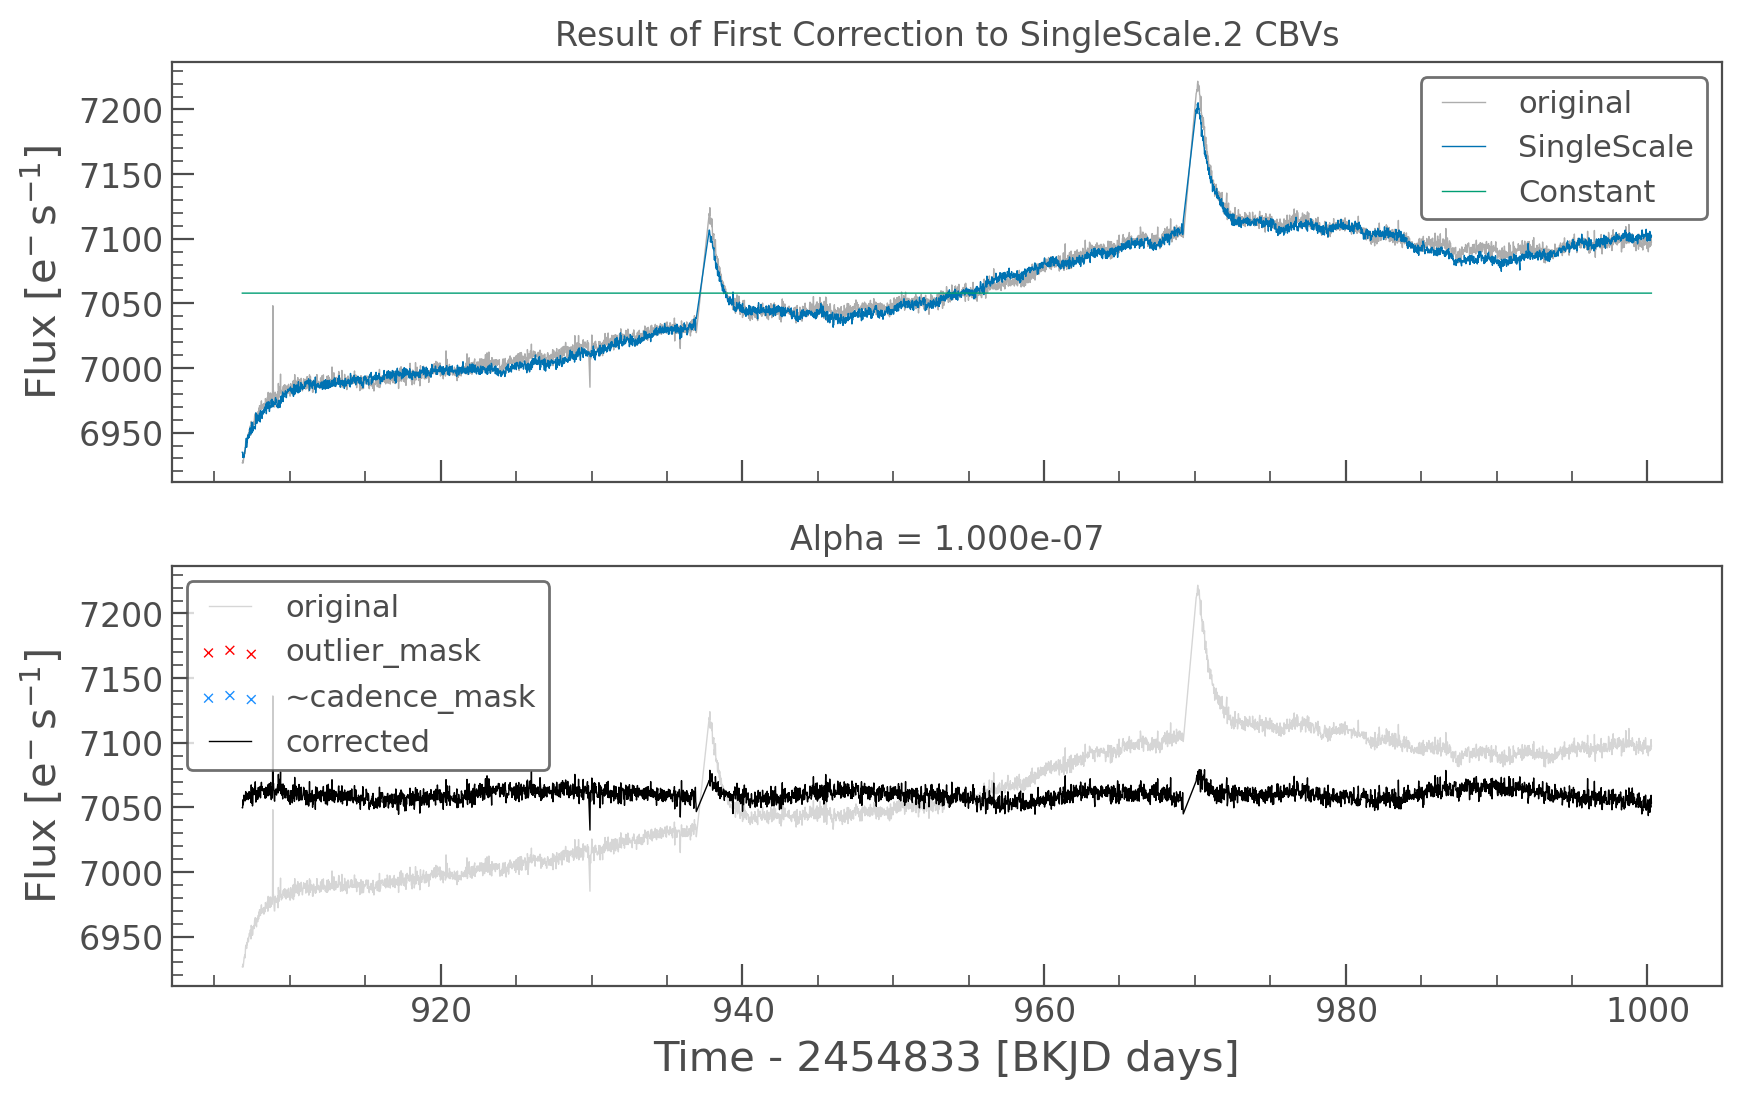

In [15]:
# Fit to the Multi-Scale Band 2 CBVs with ElasticNet to add in a L1-Norm (Lasso) term
cbvCorrector.correct_elasticnet(cbv_type=['SingleScale'], cbv_indices=[np.arange(1,9)], alpha=1.0e-7, l1_ratio=0.5)
ax = cbvCorrector.diagnose()
ax[0].set_title('Result of First Correction to SingleScale.2 CBVs');

Over-fitting Metric: 0.7021771490664779
Under-fitting Metric: 0.9996657630289725


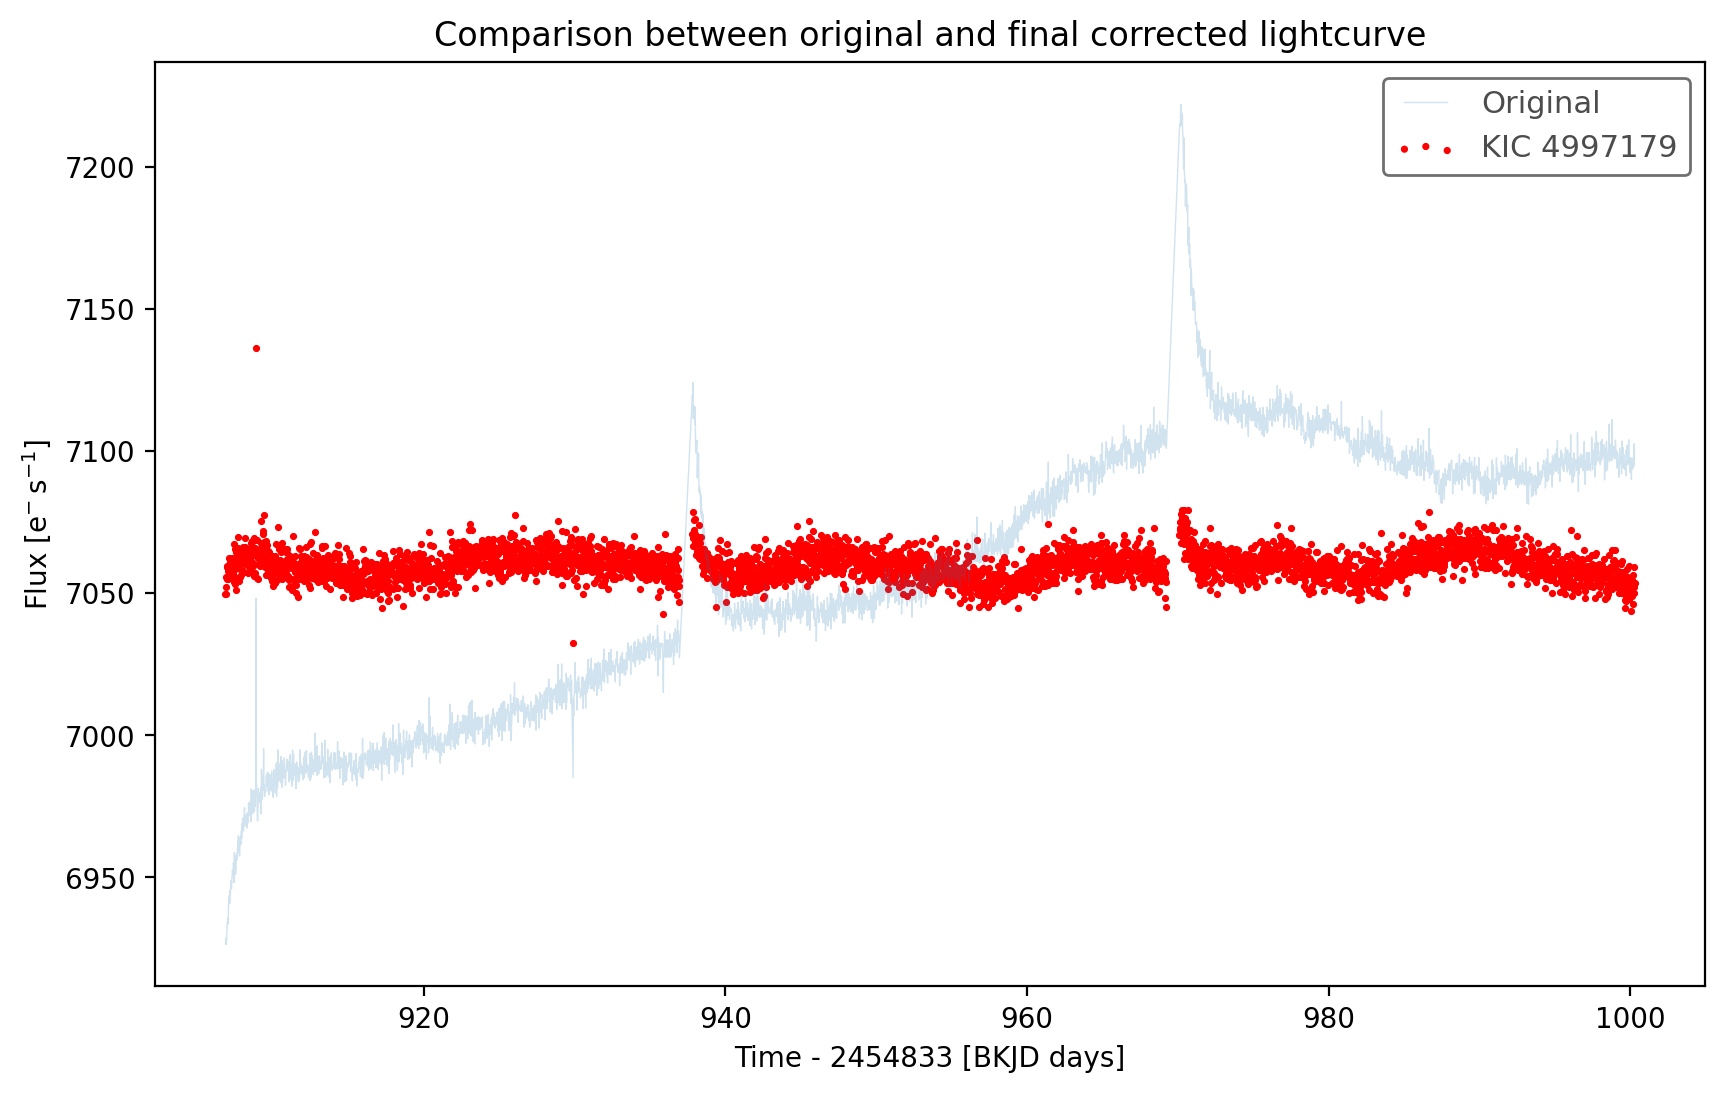

In [19]:
# Compute the final goodness metrics compared to the original lightcurve.
# This requires us to copy the original light curve into cbvCorrectorIter2.lc so that the goodness metrics compares the corrected_lc to the proper initial light curve.
print('Over-fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under-fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

# Plot the final correction
_, ax = plt.subplots(1, figsize=(10, 6))
cbvCorrector.lc.plot(ax=ax, normalize=False, alpha=0.2, label='Original')
cbvCorrector.corrected_lc.scatter(normalize=False, c='r', marker='.',
                                            s=10, ax=ax)
ax.set_title('Comparison between original and final corrected lightcurve');

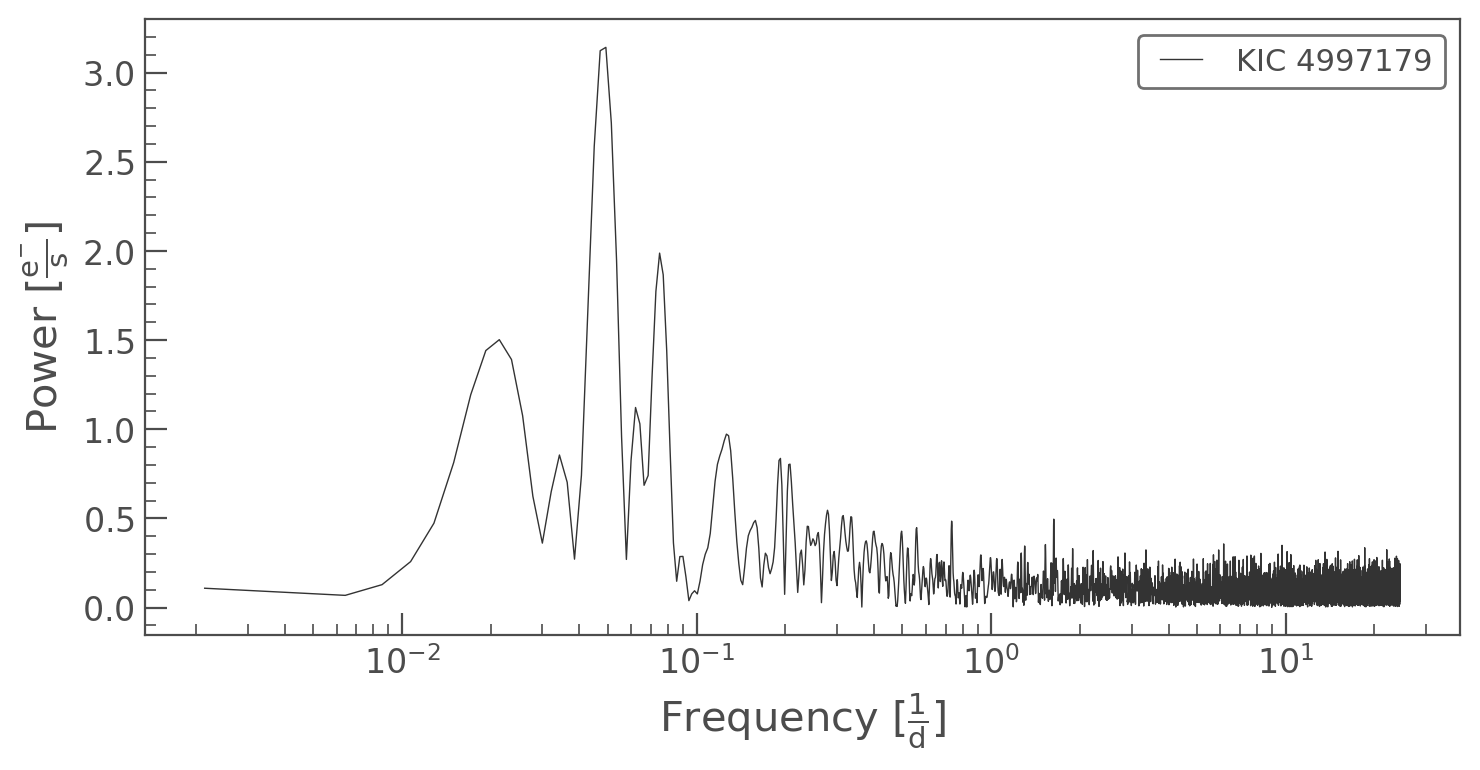

In [30]:
pg = cbvCorrector.corrected_lc.to_periodogram()
ax = pg.plot()
ax.set_xscale('log')
ax.axvline()

So, which CBVs are best to use? There is no one single answer, but generally speaking, the Multi-Scale Basis vectors are more versatile. The trade-off is there are also more of them, which means more degrees of freedom in your fit. More degrees of freedom can result in more over-fitting without proper regularization. It is recommened the user tries different combinations of CBVs and use objective metrics to decide which fit is the best for their particular needs.

## Using the Goodness Metrics and CBVCorrector with other Design Matrices

The Goodness Metrics and CBVCorrector can also be used in conjunction with other external design matrices. Let's work on a famous planet example to show how the CBVCorrector can be utilized to imporove the generated light curve. We will begin by using [search_tesscut](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut) to extract an FFI light curve for HAT-P 11 and then create a DesignMatrix using the background pixels.

In [49]:
import pandas as pd

In [50]:
corrected_lc = cbvCorrector.corrected_lc

In [102]:
lc = lc.remove_nans()

In [103]:
t_vec = lc.time.value

In [104]:
t_vec

array([ 906.84645522,  906.86688949,  906.88732366, ..., 1000.22761695,
       1000.24804982, 1000.26848259])

In [105]:
period = pg.period_at_max_power.value

In [106]:
n_cad = len(t_vec)

In [107]:
df_dm = pd.DataFrame({'sine_term':np.sin(2*np.pi*t_vec/period),
             'cos_term':np.cos(2*np.pi*t_vec/period),
             'constant_term':np.ones_like(t_vec)})

In [108]:
from lightkurve.correctors import DesignMatrix
dm = DesignMatrix(df_dm, name='star')

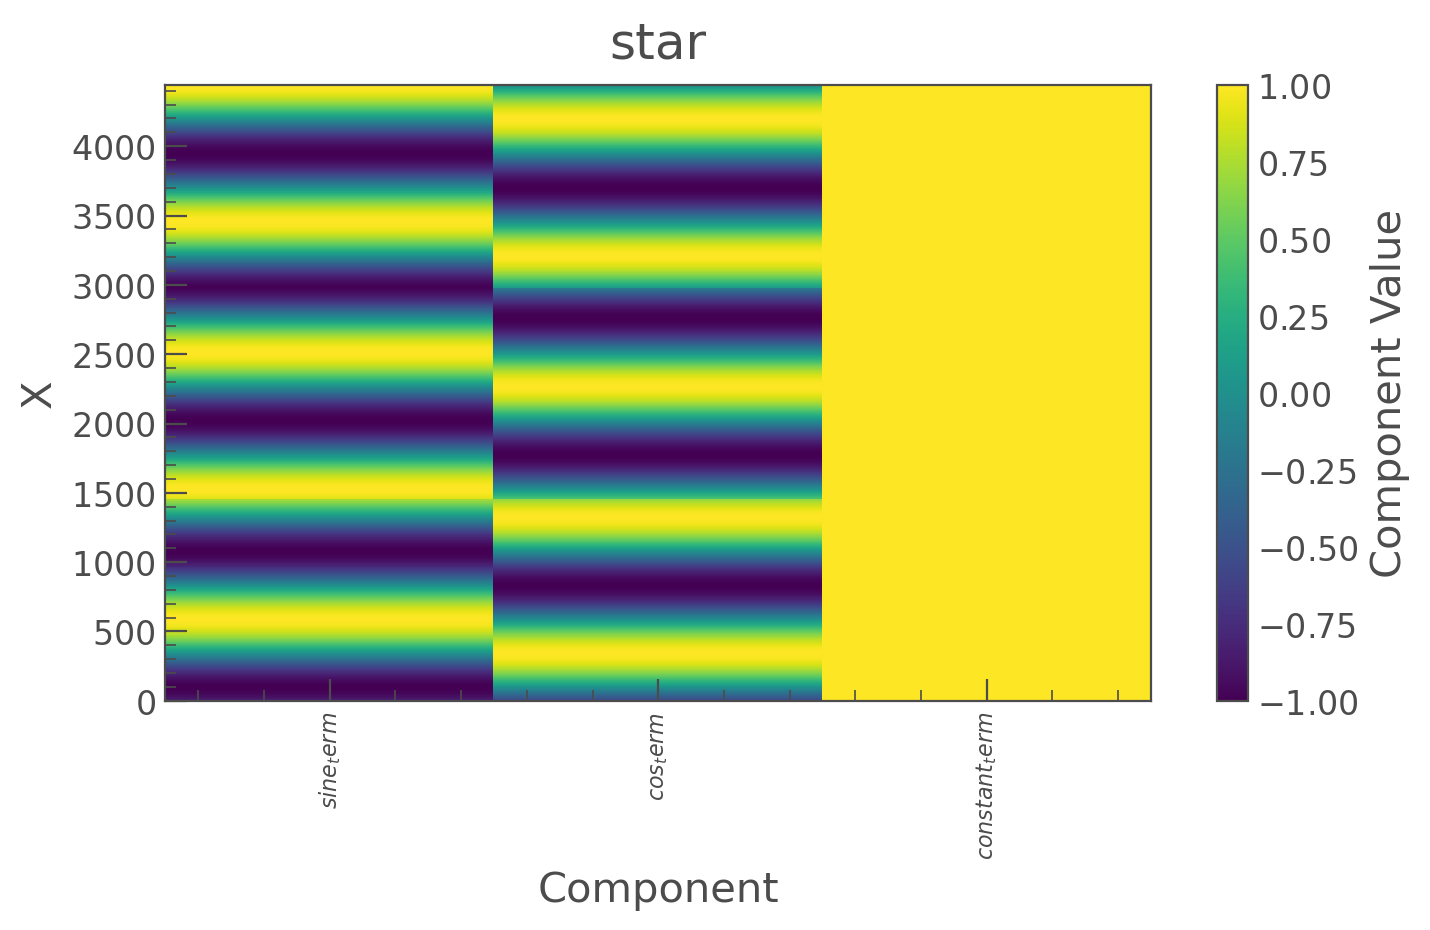

In [109]:
ax = dm.plot(vmin=-1)

The [DesignMatrix](https://docs.lightkurve.org/reference/api/lightkurve.correctors.DesignMatrix.html?highlight=designmatrix#lightkurve.correctors.DesignMatrix) `dm` now contains the common trends in the background pixels in the data. We will first try to fit the pixel-based design matrix using an unrestricted least-squares fit (I.e. a very weak regularization by setting alpha to a small number). We tell CBVCorrector to only use the external design matrix with `ext_dm=`. When we generate the CBVCorrector object the CBVs will be downloaded, but the CBVs are for 2-minute cadence and not the 30-minute FFIs. We therefore use the `interpolate_cbvs=True` option to tell the CBVCorrector to interpolate the CBVs to the light curve cadence.

In [110]:
# Generate the CBVCorrector object and interpolate the downloaded CBVs to the light curve cadence
cbvcorrector = CBVCorrector(lc, interpolate_cbvs=True, extrapolate_cbvs=True)

AssertionError: cbvCorrector expects light curve to be passed in e-/s units.

In [94]:
df_dm.shape

(4443, 3)

In [95]:
dm.shape

(4443, 3)

In [96]:
lc.flux.shape

(4443,)

In [97]:
lc.remove_nans().flux.shape

(4443,)

In [99]:
# Perform an unrestricted least-squares fit using only the pixel-derived design matrix.
cbvcorrector.correct_gaussian_prior(cbv_type=None, cbv_indices=None, ext_dm=dm, alpha=1e-4)

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
906.8464552195001,6.9318519e+03,3.0312879e+00,0,3.022399e-03,473.23530,24.35878,39049,6.9266479e+03,3.0312879e+00,6.2332690e+02,3.0575430e-01,———,———,0,———,———,———,———,473.23530,5.4035272e-04,24.35878,5.3737068e-04,-4.8440292e-02,-1.2506612e-01
906.8668894878356,6.9316817e+03,3.0314955e+00,0,3.022968e-03,473.23552,24.35865,39050,6.9264590e+03,3.0314956e+00,6.2451129e+02,3.0574101e-01,9.1494219e+03,3.9196181e+00,0,———,———,———,———,473.23552,5.4026255e-04,24.35865,5.3739105e-04,-4.8481617e-02,-1.2505126e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000.2276169520046,7.0885828e+03,3.0482430e+00,0,2.613632e-03,473.32734,24.57157,43619,7.0947710e+03,3.0482430e+00,6.2696338e+02,3.0526137e-01,9.1653369e+03,3.9512844e+00,0,———,———,———,———,473.32734,5.4269930e-04,24.57157,5.4473052e-04,5.3210855e-02,1.3209906e-01
1000.2480498218501,7.0963263e+03,3.0489256e+00,0,2.612902e-03,473.32602,24.57103,43620,7.1025103e+03,3.0489256e+00,6.2645667e+02,3.0557996e-01,9.1727100e+03,3.9514701e+00,0,———,———,———,———,473.32602,5.4185931e-04,24.57103,5.4379320e-04,5.3143997e-02,1.3232988e-01
1000.2684825914621,7.0913390e+03,3.0485453e+00,0,2.612171e-03,473.32954,24.57038,43621,7.0975186e+03,3.0485454e+00,6.2656921e+02,3.0511710e-01,9.1645410e+03,3.9508810e+00,0,———,———,———,———,473.32954,5.4183998e-04,24.57038,5.4375647e-04,5.3363580e-02,1.3203950e-01


array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:title={'center':'Alpha = 1.000e-04'}, xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

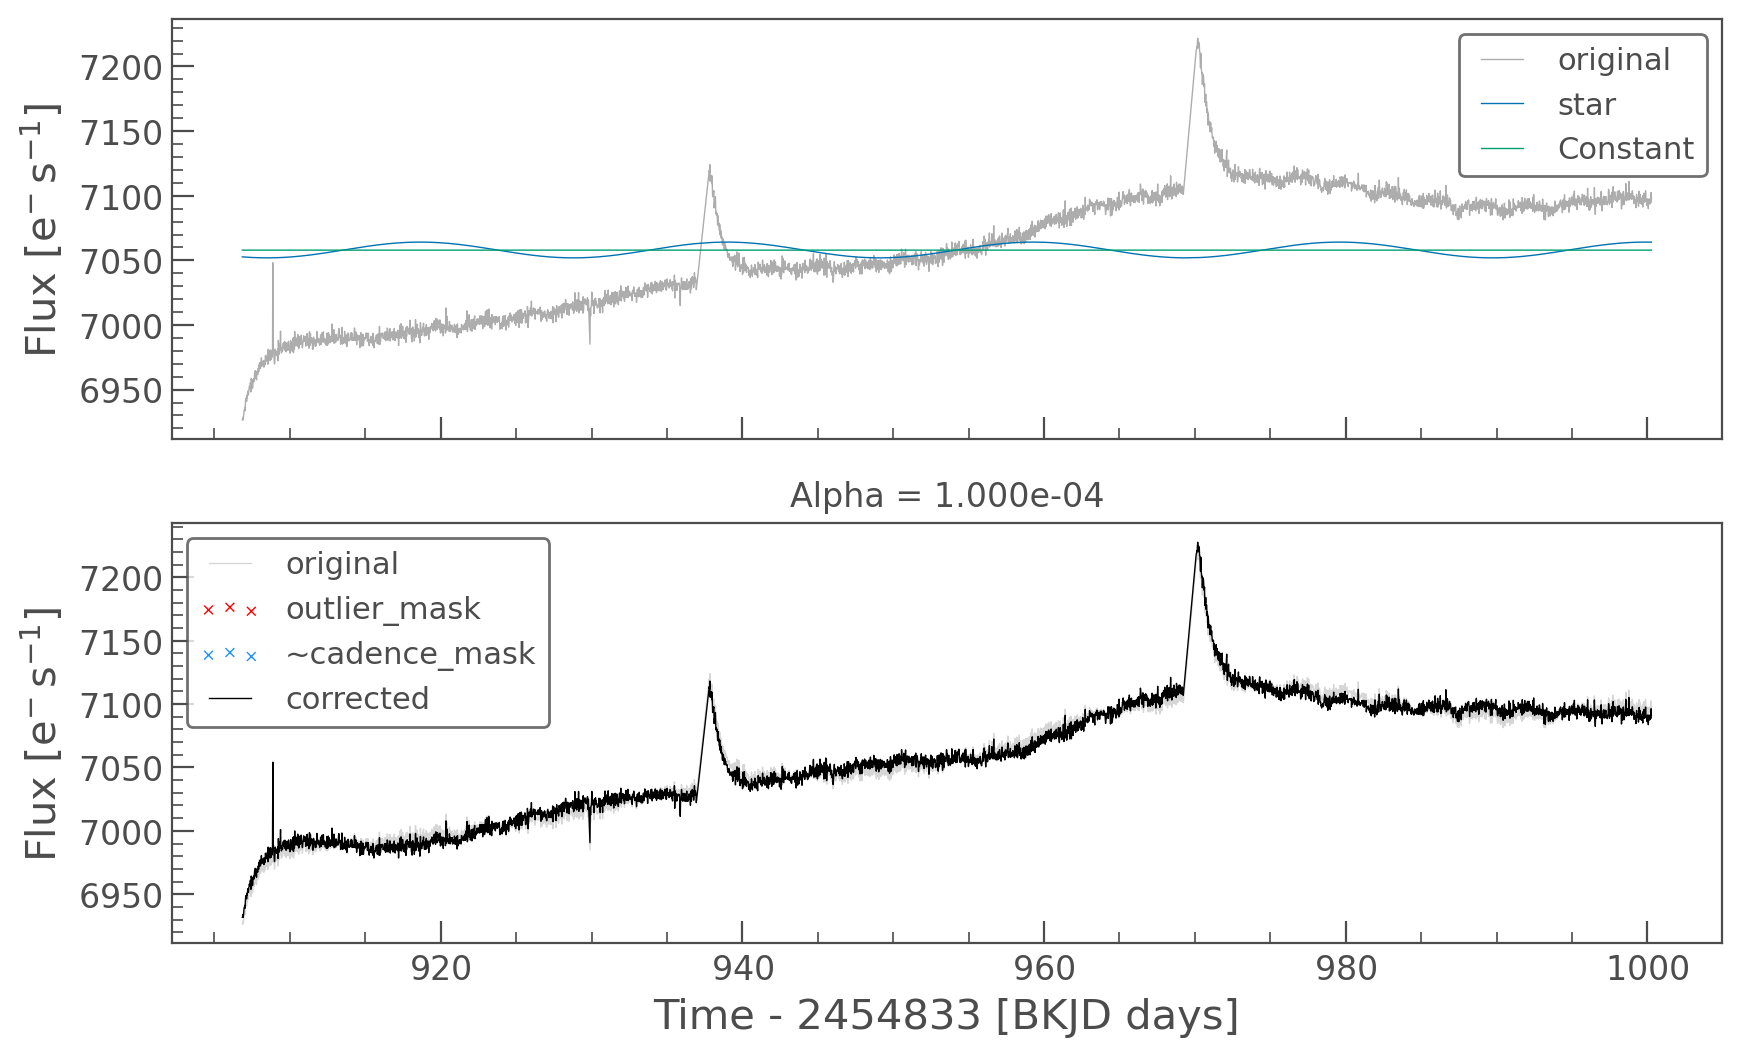

In [100]:
cbvcorrector.diagnose()

In [101]:
print('Over-fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_just_pixel_dm = cbvcorrector.corrected_lc

Over-fitting metric: 0.9118943049883168


ValueError: could not broadcast input array from shape (4443,) into shape ()

The least-squares fit did remove the background flux trend and at first sight the resultant might look good, but the over-fitting goodness metric is `0.08`. That's not very good! It looks like we are dramatically over-fitting. We can see this in the bottom plot where the corrected curve has more high-frequency noise than the original. Let's now add in the multi-scale basis vectors and see if we can do better. Note that we are joint fitting the CBVs and the external pixel-derived design matrix.

In [ ]:
cbv_type = ['MultiScale.1', 'MultiScale.2', 'MultiScale.3','Spike']
cbv_indices = [np.arange(1,9), np.arange(1,9), np.arange(1,9), 'ALL']
cbvcorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm, alpha=1e-4)
cbvcorrector.diagnose()
print('Over-fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_joint_fit = cbvcorrector.corrected_lc

That looks a lot better! Could we do a bit better by adding in a regularization term? Let's do a goodness metric scan.

In [ ]:
cbvcorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm);

There are a couple observations to make here. 

First, the under-fitting metric has a very good score throughout the regularization scan. This is because the under-fitting metric compares the corrected light curve to neighboring targets in RA and Decl. that are archived as 2-minute SAP-flux targets. _The SAP flux already has the background removed_ so the neighoring targets do not contain the very large background trends. The under-fitting metric is therefore not very helpful. In the next run we will disable the under-fitting metric in the optimization (by setting target_under_score=-1).

We see the over-fitting metric is not a simple function of the regularization factor _alpha_. This can happen due to the interaction of the various basis vectors during fitting when regularization is applied. We see a minima (most over-fitting) at about alpha=1e-1. Once alpha moves above this value we begin to over-constrain the fit which results in gradually less removal of systematics. The under-fitting metric should be an indicator that we are going too far constraining the fit, and indeed, we do see the under-fitting metric degrades slightly beginning at alpha=1e-1.

We will now try to optimize the fit and account for these two issues by 1) setting the bounds on the alpha parameter (`alpha_bounds=[1e-6, 1e-2]`) and 2) disregarding the under-fitting metric (`target_under_score=-1`).

In [ ]:
# Optimize the fit but ignore the under-fitting metric and set bounds on the alpha parameter.
cbvcorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm, alpha_bounds=[1e-6, 1e-2], target_over_score=0.8, target_under_score=-1)
cbvcorrector.diagnose();
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))

This is looking like a pretty good light curve. However, the CDPP increased a little as we optimized the over-fitting metric. Which correction to use may depend on your application. Since we are interested in the transiting planet, we will choose the corrected light curve with the lowest CDPP. Below we compare the light curve between just using the pixel-derived design matrix to also adding in the CBVs as a joint, regularized  fit.

In [ ]:
_, ax = plt.subplots(3, figsize=(10, 6))
cbvcorrector.lc.plot(ax=ax[0], normalize=False, label='Uncorrected LC', c='k')
corrected_lc_just_pixel_dm.plot(normalize=False, label='Pixel-Level Corrected; CDPP={0:.1f}'.format(corrected_lc_just_pixel_dm.estimate_cdpp()), ax=ax[1], c='m')
corrected_lc_joint_fit.plot(normalize=False, label='Joint Fit Corrected; CDPP={0:.1f}'.format(corrected_lc_joint_fit.estimate_cdpp()), ax=ax[2], c='b')
ax[0].set_title('Comparison Between original and final corrected lightcurve');

The superiority of the bottom curve is blatantly obvious. We can clearly see HAT-P 11b on it's 4.9 day period orbit. Our over-fitting metric settled at about 0.35 indicating we might still be over-fitting and should keep that in mind. However the low CDPP indicates the over-fitting is probably not over transit time-scales. 

## Some final comments on CBVCorrector

### Application to Kepler vs K2 vs TESS

CBVCorrector works equally across Kepler, K2 and TESS. However the Multi-Scale and Spike basis vectors are only available for TESS[<sup>1</sup>](#fn1). For K2, the [PLDCorrector](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-pldcorrector.html) and [SFFCorrector](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-sffcorrector.html) classes might work better than `CBVCorrector`.

If you want to just get the CBVs but not generate a CBVCorrector object then use the functions _load_kepler_cbvs_ and _load_tess_cbvs_ within the cbvcorrector module as explained [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-how-to-use-cbvs.html).

<sup>1</sup><span id="fn1"> Unfortunately, the Multi-Scale and Spike CBVs are not archived at MAST for Kepler/K2.</span>

### Applicability of the Over- and Under-fitting Goodness Metrics

The under-fitting metric computes the correlation between the corrected light curve and a selection of neighboring SPOC SAP light curves. If the light curve you are trying to correct was not generated by the SPOC pipeline (I.e. not a SAP light curve), then the neighboring SAP light curves might not contain the same instrumental systematics and the under-fitting metric might not properly measure when under-fitting is occuring. 

The over-fitting metric examines the periodogram of the light curve before and after the correction and is therefore indifferent to how the light curve was generated. It simply looks to see if noise was injected into the light curve. The over-fitting metric is therefore much more generally applicable.

The Goodness Metrics are part of the `lightkurve.correctors.metrics` module and can be computed directly with calls to `overfit_metric_lombscargle` and `underfit_metric_neighbors`. A savvy expert user can use these and other quality metrics to generate their own Loss Function for optimizing a fit.

### Aligning versus Interpolating CBVs

By default, all loaded CBVS in `CBVCorrector` are "aligned" to the light curve cadence numbers (`CBVCorrector.lc.cadenceno`). This means only cadence numbers that exist in both the CBVs and the light curve will have values in the returned CBVs. All cadence numbers that exist in the light curve but not in the CBVs will have NaNs returned for the CBVs on those cadences and the Gap Indicator set to True. Any cadences in the CBVs not in the light curve will be removed from the CBVs.


If the light curve cadences do not overlap well with the CBVs then you can set `interpolate_cbvs=True` when generating the `CBVCorrector` object. Doing so will generate interpolated CBV values for all cadences in the light curve. If the light curve has cadences past either end of the cadences in the CBVs then one must extrapolate. A second argument, `extrapolate_cbvs`, can be used to also extrapolate the CBV values to the light curve cadences. If `extrapolate_cbvs=False` then the exterior values are set to NaNs, which will probably result is a very poor fit.

**Warning**: *The safest method is to align*. This will not generate any new values for the CBVs. Interpolation can be potentially dangerous. Interpolation uses Piecewise Cubic Hermite Interpolating Polynomial (PCHIP), which can be more stable than a simple spline, but no interpolation method works in all situations. Extrapolation is even more dangerious, which is why an extra parameter must be set if one desires to extrapolate. *Be sure to manually examine the extrapolated CBVs before use!*

### Joint Fitting

By including the `ext_dm=` parameter in the `correct_*` methods we allow for joint fitting between the CBVs and other design matrices. Generally speaking, if fitting a collection of different models to a system, joint fitting is ideal. For example, if performing transit analysis one could add in a transit model to the joint fit to get the best transit recovery. The fit coefficient to the transit model is stored in the `CBVCorrector` object after fitting and can be recovered.

### Hyperparameter Optimization

Any model fitting should include a hyperparameter optimization step. The `correct_optimizer` is essentially a 1-dimensional optimizer and is very fast. More advanced hypterparameter optimization can be performed by tuning the `alpha` and `l1_ratio` parameters in `correct_elasticnet` plus the number and type of CBVs, along with an external design matrix. The optimization Loss Function can use a combination of the `under_fitting_metric`, `over_fitting_metric` and `lc.estimate_cdpp` methods. Writing such an optimzer is left as an exercise to the reader and to be tuned to the reader's particular application.

### More Generalized Design Matrix Priors

The main [CBVCorrector.correct*](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html?highlight=cbvcorrector%20correc#lightkurve.correctors.CBVCorrector) methods utilize a similar prior for all design matrix vectors as is typically used in L1-Norm and L2-Norm regularization. However you can perform fine tuning to the correction using more sophisticated priors. After performing a fit with one of the `CBVCorrector.correct*` methods, `CBVCorrector.design_matrix_collection` will have the priors set. One can then manually adjust the priors and use `CBVCorrector.correct_regressioncorrector` to perform the standard [RegressionCorrector.correct](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.correct.html?highlight=regressioncorrector%20correct#lightkurve.correctors.RegressionCorrector.correct) correction. An illustration is below:

In [ ]:
# 1) Perform an initial optimization with a L2-Norm regularization
# cbvCorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices);

# 2) Examine the quality of the resultant lightcurve in cbvcorrector.corrected_lc
# Determine how to adjust the priors and make changes to the design matrix
# cbvCorrector.design_matrix_collection[i].prior_sigma[j] = # ... adjust the priors

# 3) Call the superclass correct method with the adjusted design_matrix_collection
# cbvCorrector.correct_regressioncorrector(cbvCorrector.design_matrix_collection, **kwargs)

The `cbvCorrector.corrected_lc` will now be the result of the fit using whatever `cbvCorrector.design_matrix_collection` you had just provided.

### NaNs, Units and Normalization

NaNs are removed from the light curve when used to generate the `CBVCorrector` object and is stored in `CBVCorrector.lc`. 

The CBVCorrector performs its corrections in absolute flux units (typically electrons per second). The returned corrected light curve `corrected_lc` is also in absolute units and the median flux of the light curve is preserved.

In [ ]:
print('LC unit: {}'.format(cbvCorrector.lc.flux.unit))
print('Corrected LC unit: {}'.format(cbvCorrector.corrected_lc.flux.unit))

The goodness metrics are computed using median normalized units in order to properly calibrate the metric to be between 0.0 and 1.0 for all light curves. The normalization is as follows:

In [ ]:
normalized_lc = cbvCorrector.lc.normalize()
normalized_lc -= 1.0
print('Normalized Light curve units: {} (i.e astropy.units.dimensionless_unscaled)'.format(normalized_lc.flux.unit))